In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dataset import defectDataset_df, create_circular_mask
import random
import math
import seaborn
from  matplotlib import pyplot

In [2]:
def sample_point_circular(circle_min = 0.02, circle_max = 0.07):
    # random angle
    alpha = 2 * math.pi * random.random()
    # random radius
    r = (circle_max - circle_min) * random.random() + circle_min
    # calculating coordinates
    x = r * math.cos(alpha)
    y = r * math.sin(alpha)
    return x,y

In [3]:
window_size = 45
pad_size = window_size
classes = ["pos","neg","pos_o","nuc","non"]

In [4]:
img_path = '/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/'
csv_path = '/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv'
df_defect = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/labels.csv', sep=" ")
df_train = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv', sep=" ")
df_test = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" ")

In [5]:
df_pos = df_train[df_train['class'] == 0]
df_neg = df_train[df_train['class'] == 1]
df_pos_o = df_train[df_train['class'] == 2]
df_nuc = df_train[df_train['class'] == 3]

In [6]:
print(df_pos.shape, df_neg.shape, df_pos_o.shape, df_nuc.shape)

(16102, 4) (7614, 4) (4719, 4) (1995, 4)


In [7]:
def split_and_sample(df_train = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv', sep=" ")
                             , n_samples = 1000, non_inner_circle = 0.02, non_outer_circle = 0.07, method = 'uniform'):
    df_pos = df_train[df_train['class'] == 0]
    df_neg = df_train[df_train['class'] == 1]
    df_pos_o = df_train[df_train['class'] == 2]
    df_nuc = df_train[df_train['class'] == 3]
    frames = [df_pos.sample(n=n_samples), df_neg.sample(n=n_samples), df_pos_o.sample(n=n_samples), df_nuc.sample(n=n_samples)]
    df_train_samples = pd.concat(frames)
    df_train_non = df_train_samples.sample(n=n_samples)
    # print(df_train_non.head(10))
    if method=='hard':
        for index, row in df_train_non.iterrows():
            min_dis = 0  # make sure go in for loop
            while min_dis < non_inner_circle:
                dx,dy = sample_point_circular(non_inner_circle, non_outer_circle)
                new_point = [row.x+dx, row.y+dy]
                df_image = df_train[df_train['image_index'] == row['image_index']] # retrive all points in the image
                min_dis = 1
                for index_im, row_im in df_image.iterrows(): # check distance from new_point to each point, if smaller than threshold than thow away
                    dis = math.sqrt(math.pow(new_point[0]-row.x,2)+math.pow(new_point[1]-row.y,2))
                    if dis < min_dis:
                        min_dis = dis
            df_train_non.at[index,'x'] = new_point[0]
            df_train_non.at[index,'y'] = new_point[1]
            df_train_non.at[index,'class'] = 4
    elif method=='uniform':
        for index, row in df_train_non.iterrows():
            min_dis = 0
            while min_dis < non_inner_circle:
                new_point = [random.random(),random.random()]
                df_image = df_train[df_train['image_index'] == row['image_index']]
                min_dis = 1
                for index_im, row_im in df_image.iterrows():
                    dis = math.sqrt(math.pow(new_point[0]-row.x,2)+math.pow(new_point[1]-row.y,2))
                    if dis < min_dis:
                        min_dis = dis
            df_train_non.at[index,'x'] = new_point[0]
            df_train_non.at[index,'y'] = new_point[1]
            df_train_non.at[index,'class'] = 4
    df_train_samples = df_train_samples.append(df_train_non)
    df_train_samples = df_train_samples.reset_index()
    df_train_samples = df_train_samples.drop(['index'],axis = 1)
    return df_train_samples

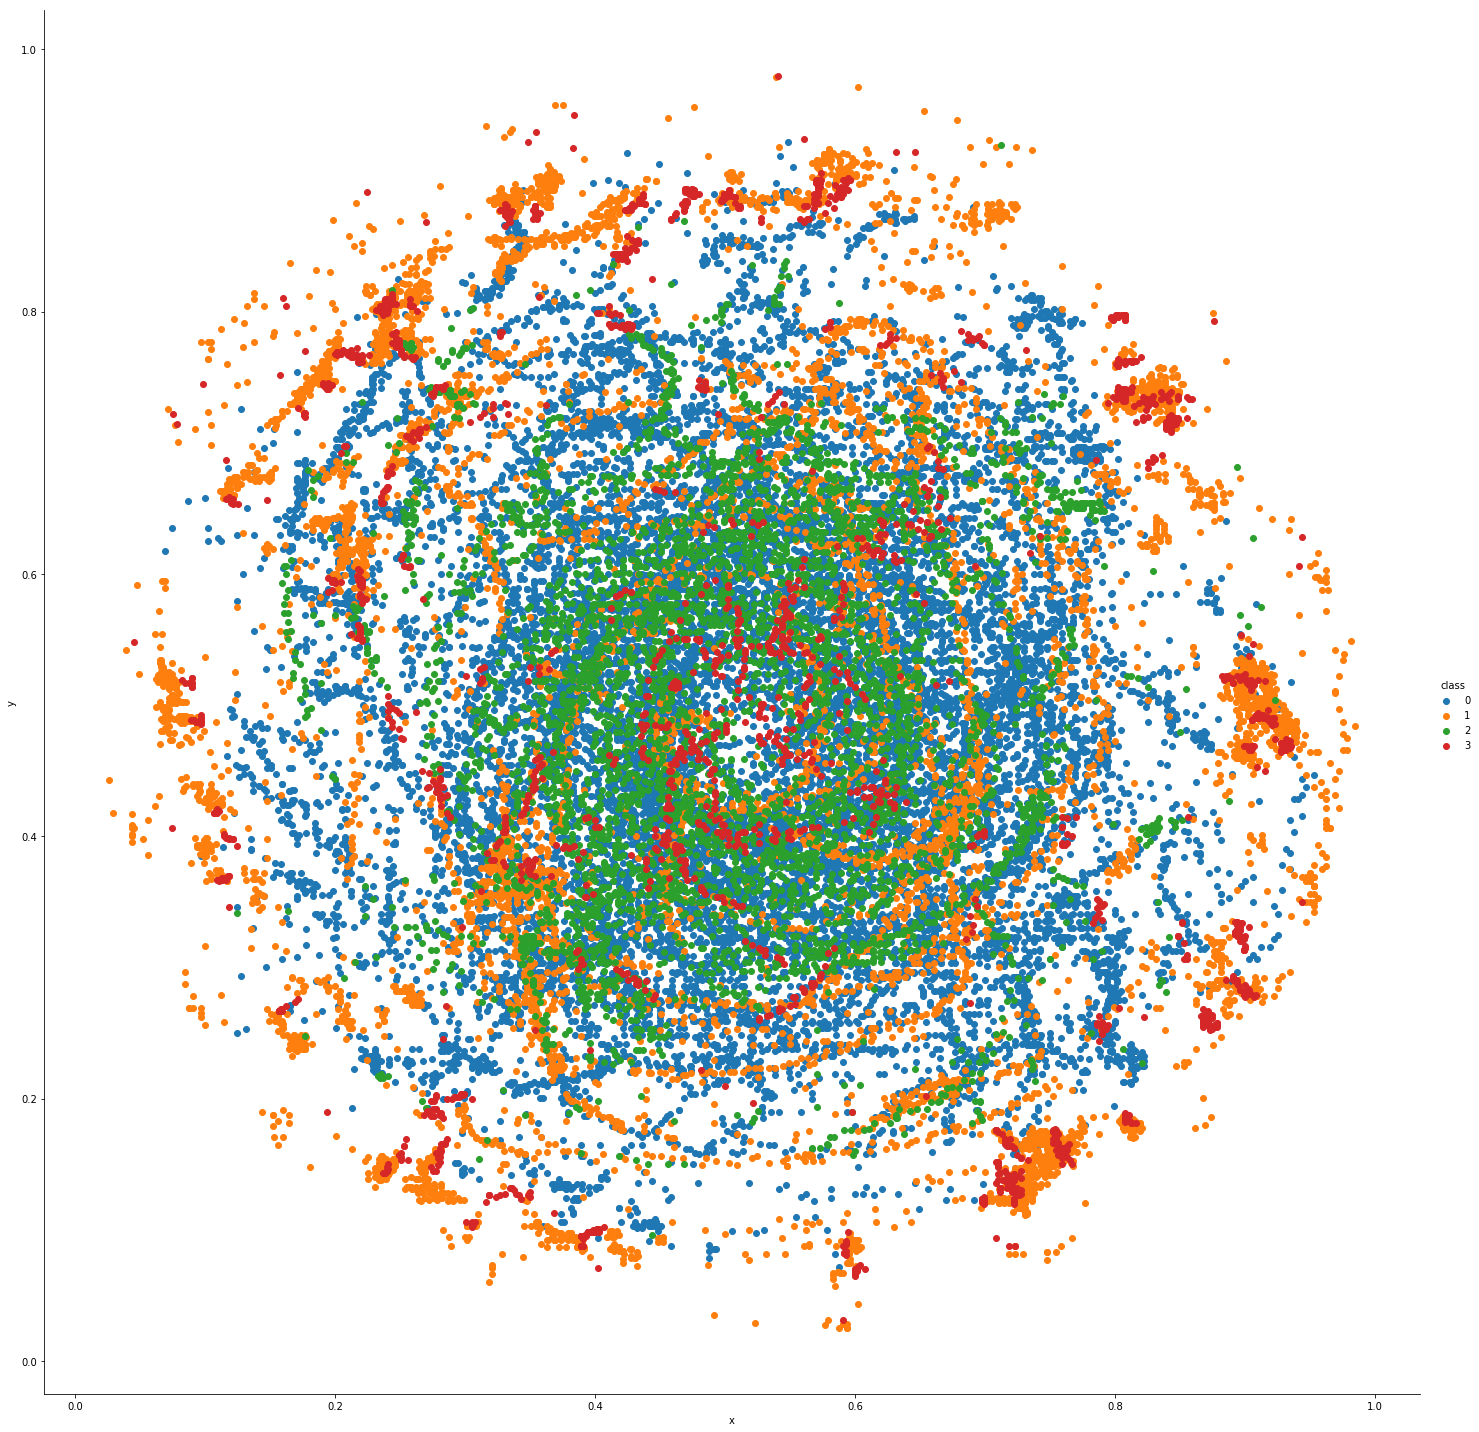

In [7]:
fg = seaborn.FacetGrid(data=df_train, hue='class', height = 20, aspect=1)
fg.map(pyplot.scatter, 'x', 'y').add_legend()
# classes = ["pos","neg","pos_o","nuc","non"]

In [142]:
n_samples = 1000
non_small_circle = 0.02
non_big_circle = 0.07
df_pos = df_train[df_train['class'] == 0]
df_neg = df_train[df_train['class'] == 1]
df_pos_o = df_train[df_train['class'] == 2]
df_nuc = df_train[df_train['class'] == 3]
frames = [df_pos.sample(n=n_samples), df_neg.sample(n=n_samples), df_pos_o.sample(n=n_samples), df_nuc.sample(n=n_samples)]
df_train_samples = pd.concat(frames)
df_train_non = df_train_samples.sample(n=n_samples)
# print(df_train_non.head(10))
for index, row in df_train_non.iterrows():
    min_dis = 0
    while min_dis < non_small_circle:
        dx,dy = sample_point_circular(non_small_circle, non_big_circle)
        new_point = [row.x+dx, row.y+dy]
        df_image = df_train[df_train['image_index'] == row['image_index']]
        min_dis = 1
        for index_im, row_im in df_image.iterrows():
            dis = math.sqrt(math.pow(new_point[0]-row.x,2)+math.pow(new_point[1]-row.y,2))
            if dis < min_dis:
                min_dis = dis
    df_train_non.at[index,'x'] = row.x + dx
    df_train_non.at[index,'y'] = row.y + dy
    df_train_non.at[index,'class'] = 4

In [8]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(200, scale=(1, 1), ratio=(1, 1)),
        transforms.RandomRotation((-90,90)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [15]:
defect_dataset = defectDataset_df(df = split_and_sample(method = 'hard',n_samples = 1000), window_size = window_size, transforms=data_transform)
dataset_loader = torch.utils.data.DataLoader(defect_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

In [16]:
def imshow(img):
    img = img * 0.1909 + 0.3019     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

GroundTruth:    non pos_o   nuc   pos   nuc   non   nuc   pos
tensor([4, 2, 3, 0, 3, 4, 3, 0])


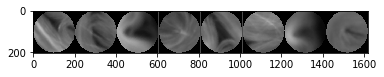

In [24]:
dataiter = iter(dataset_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
classes = ["pos","neg","pos_o","nuc","non"]
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(labels)

In [ ]:
trainset = defectDataset(csv_path='/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv',
                                             window_size = window_size, transforms=data_transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)
print("trainloader ready!")

testset = defectDataset(csv_path='/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv',
                                             window_size = window_size, transforms=data_transform)

testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=4)
print("testloader ready!")

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ["pos","neg","pos_o","nuc","non"]
num_of_classes = len(classes)

